In [644]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
l=[]
for i in ['201806','201807','201808','201809','201810','201811','201812','201901','201902']:
    Df = pd.read_csv('./Supply/'+i+'.csv')
    l.append(Df)
combined=pd.concat(l).reset_index(drop=True)

In [664]:
Df=combined.fillna(0)

In [665]:
len(Df)/12/24

272.98611111111114

In [668]:
Renewable=np.array([np.mean(Df['Renewables'][i*12:(i+1)*12]) for i in range(int(len(Df)/12))])
NG=np.array([np.mean(Df['Natural gas'][i*12:(i+1)*12]) for i in range(int(len(Df)/12))])
Hydro=np.array([np.mean(Df['Large hydro'][i*12:(i+1)*12]) for i in range(int(len(Df)/12))])
Import=np.array([np.mean(Df['Imports'][i*12:(i+1)*12]) for i in range(int(len(Df)/12))])
Nuclear=np.array([np.mean(Df['Nuclear'][i*12:12*(i+1)]) for i in range(int(len(Df)/12))])
Coal=np.array([np.mean(Df['Coal'][i*12:(i+1)*12]) for i in range(int(len(Df)/12))])

In [654]:
l=[]
for i in ['20180601','20180701','20180715','20180801','20180815','20180901','20181001','20181015','20181101','20181201','20190101','20190201']:
    Df = pd.read_csv(i+'_hourly_prices.csv')
    l.append(Df)
Df2=pd.concat(l).reset_index(drop=True)

C:\Users\DingR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [655]:
Df2.keys()

Index(['106THSO_LNODED1', '118THSO_LNODER1', '13THSO_LNODE-3',
       '13THSO_LNODED2', '23RDST_LNODED3', '26FTDROP_GNODEIT',
       '2C559EQ2_7_N001', '3RDWEST_LNODED1', '3RDWEST_LNODED2',
       '5THWEST_LNODED1',
       ...
       'YU_GNODEYUGT2', 'YU_GNODEYUGT3', 'YU_GNODEYUGT4', 'YU_GNODEYUGT5',
       'YU_GNODEYUGT6', 'YU_GNODEYUST1', 'ZACA_1_N001', 'ZAMORA_1_N001',
       'ZANKER_1_N001', 'ZANKER_1_N003'],
      dtype='object', length=6293)

In [670]:
ts=Df2[Df2.keys()[1000]]

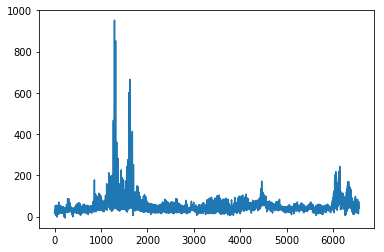

In [671]:
plt.plot(ts)

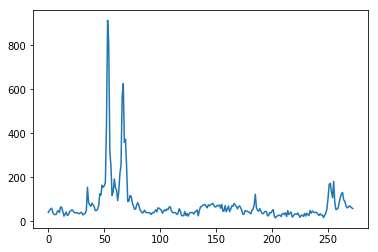

In [658]:
spread=[]
for i in range(int(len(ts)/24)):
    spread.append(np.max(ts[24*i:24*(i+1)])-np.min(ts[24*i:24*(i+1)]))
plt.plot(spread)

In [535]:
dfl=pd.read_csv('load05-09.csv')

In [536]:
load=np.array(dfl['CA ISO-TAC'])

In [512]:
demand=np.array([np.sum(load[i*24:(i+1)*24]) for i in range(2928//24)])

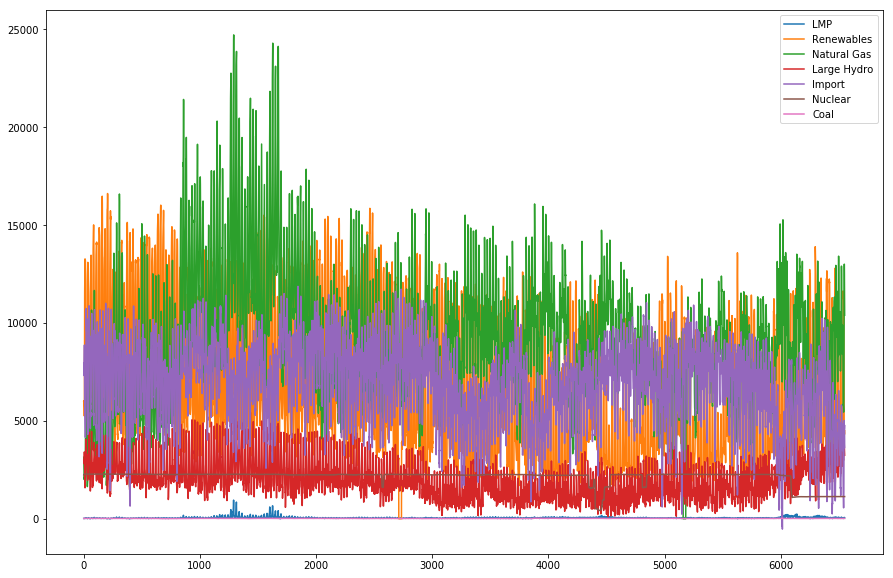

In [672]:
plt.figure(figsize=(15,10))
plt.plot(ts[:-1],label='LMP')
plt.plot(Renewable,label='Renewables')
plt.plot(NG,label='Natural Gas')
plt.plot(Hydro,label='Large Hydro')
plt.plot(Import,label='Import')
plt.plot(Nuclear,label='Nuclear')
plt.plot(Coal,label='Coal')
#plt.plot(demand,label='Load')
plt.legend()

Transforming data to similar scale

In [673]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
renewable=scaler.fit_transform(Renewable.reshape(-1,1)).reshape(1,-1)[0]
ng=scaler.fit_transform(NG.reshape(-1,1)).reshape(1,-1)[0]
hydro=scaler.fit_transform(Hydro.reshape(-1,1)).reshape(1,-1)[0]
imp=scaler.fit_transform(Import.reshape(-1,1)).reshape(1,-1)[0]
nuc=scaler.fit_transform(Nuclear.reshape(-1,1)).reshape(1,-1)[0]
coal=scaler.fit_transform(Coal.reshape(-1,1)).reshape(1,-1)[0]
d=scaler.fit_transform(np.array(load).reshape(-1,1)).reshape(1,-1)[0]
s=scaler.fit_transform(np.array(ts).reshape(-1,1)).reshape(1,-1)[0]

C:\Users\DingR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\DingR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


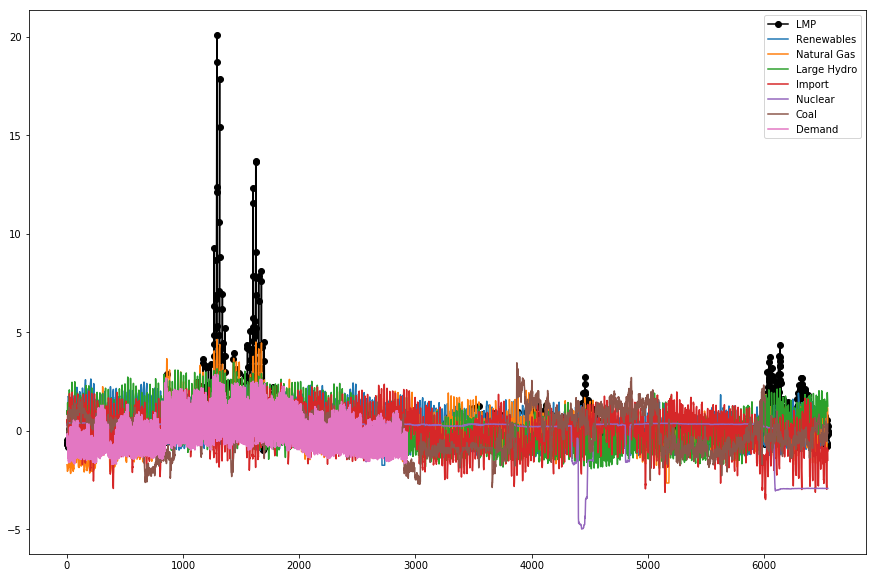

In [674]:
plt.figure(figsize=(15,10))
plt.plot(s,'ko-',label='LMP')
plt.plot(renewable,label='Renewables')
plt.plot(ng,label='Natural Gas')
plt.plot(hydro,label='Large Hydro')
plt.plot(imp,label='Import')
plt.plot(nuc,label='Nuclear')
plt.plot(coal,label='Coal')
plt.plot(d,label='Demand')
plt.legend()

In [801]:
h=30
data=np.array([list(renewable[i:i+h])+list(ng[i:i+h])+list(hydro[i:i+h])+list(imp[i:i+h])+list(s[i:i+h+1]) for i in range(len(s)-h)])

In [802]:
size=int(len(data)*0.8)
#np.random.shuffle(data)
train, test = data[0:size,:], data[size:len(data),:]
X_train,X_test=train[:,0:-1],test[:,0:-1]
y_train,y_test=train[:,-1],test[:,-1]

In [803]:
p=X_train.shape[1]

In [804]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

def nn_train(X_train,y_train,p,epoch,b_s):
    
    model=Sequential()
   
    model.add(Dense(100, input_dim=p, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='logcosh', optimizer='adam')
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.2,epochs=epoch, batch_size=b_s)
# evaluate the model
    return model
def nn_test(X_out,y_out,nn,p):
    
    y_val=np.array(nn.predict(X_out)).reshape(1,-1)[0]
    y_out=scaler.inverse_transform(y_out.reshape(-1,1)).reshape(1,-1)[0]
    y_val=scaler.inverse_transform(y_val.reshape(-1,1)).reshape(1,-1)[0]
    #print(y_val,y_out)
    plt.figure(figsize=(15,10))
    plt.plot(y_out,'k',label='true')
    plt.plot(y_val,'r',label='predicted')
    plt.title(' RMSE='+str(np.sqrt(mean_squared_error(y_val,y_out))))
    plt.legend()
    plt.figure(figsize=(15,10))
    error=y_out-y_val
    plt.plot(error,'k')
    plt.title('Error Plot p='+str(p))
    
    print('Mean Percentage Error='+str(np.sqrt(mean_squared_error(y_out,y_val))/np.mean(y_val)))

In [805]:
nn=nn_train(X_train,y_train,p,100,1000)

Train on 4173 samples, validate on 1044 samples
Epoch 1/100
4173/4173 [==============================] - 7s 2ms/step - loss: 0.2502 - val_loss: 0.0736
Epoch 2/100
4173/4173 [==============================] - 0s 26us/step - loss: 0.1414 - val_loss: 0.0639
Epoch 3/100
4173/4173 [==============================] - 0s 15us/step - loss: 0.1040 - val_loss: 0.0738
Epoch 4/100
4173/4173 [==============================] - 0s 11us/step - loss: 0.0855 - val_loss: 0.0689
Epoch 5/100
4173/4173 [==============================] - 0s 17us/step - loss: 0.0724 - val_loss: 0.0517
Epoch 6/100
4173/4173 [==============================] - 0s 15us/step - loss: 0.0636 - val_loss: 0.0397
Epoch 7/100
4173/4173 [==============================] - 0s 13us/step - loss: 0.0564 - val_loss: 0.0352
Epoch 8/100
4173/4173 [==============================] - 0s 15us/step - loss: 0.0505 - val_loss: 0.0346
Epoch 9/100
4173/4173 [==============================] - 0s 15us/step - loss: 0.0449 - val_loss: 0.0341
Epoch 10/100
4173

4173/4173 [==============================] - 0s 14us/step - loss: 0.0063 - val_loss: 0.0206
Epoch 79/100
4173/4173 [==============================] - 0s 14us/step - loss: 0.0062 - val_loss: 0.0198
Epoch 80/100
4173/4173 [==============================] - 0s 14us/step - loss: 0.0063 - val_loss: 0.0195
Epoch 81/100
4173/4173 [==============================] - 0s 13us/step - loss: 0.0058 - val_loss: 0.0206
Epoch 82/100
4173/4173 [==============================] - 0s 14us/step - loss: 0.0060 - val_loss: 0.0193
Epoch 83/100
4173/4173 [==============================] - 0s 14us/step - loss: 0.0055 - val_loss: 0.0193
Epoch 84/100
4173/4173 [==============================] - 0s 13us/step - loss: 0.0061 - val_loss: 0.0195
Epoch 85/100
4173/4173 [==============================] - 0s 13us/step - loss: 0.0059 - val_loss: 0.0196
Epoch 86/100
4173/4173 [==============================] - 0s 11us/step - loss: 0.0054 - val_loss: 0.0197
Epoch 87/100
4173/4173 [==============================] - 0s 15us/st

Mean Percentage Error=0.12641688291060496


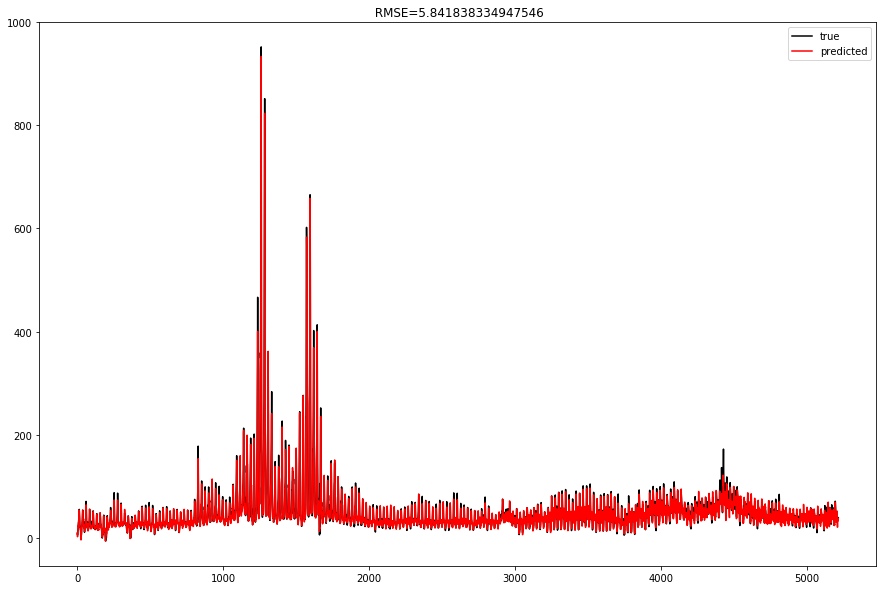

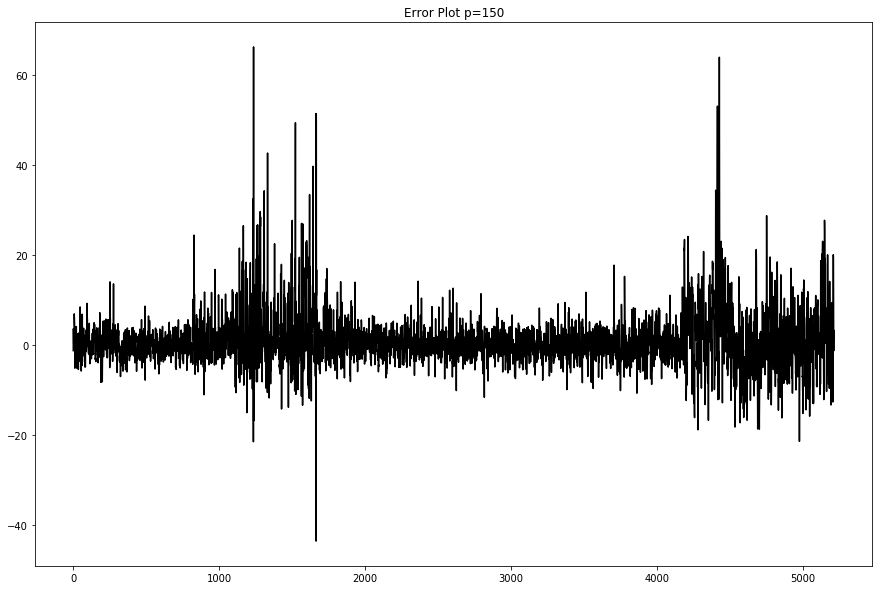

In [806]:
nn_test(X_train,y_train,nn,p)

Mean Percentage Error=0.3947985230252604


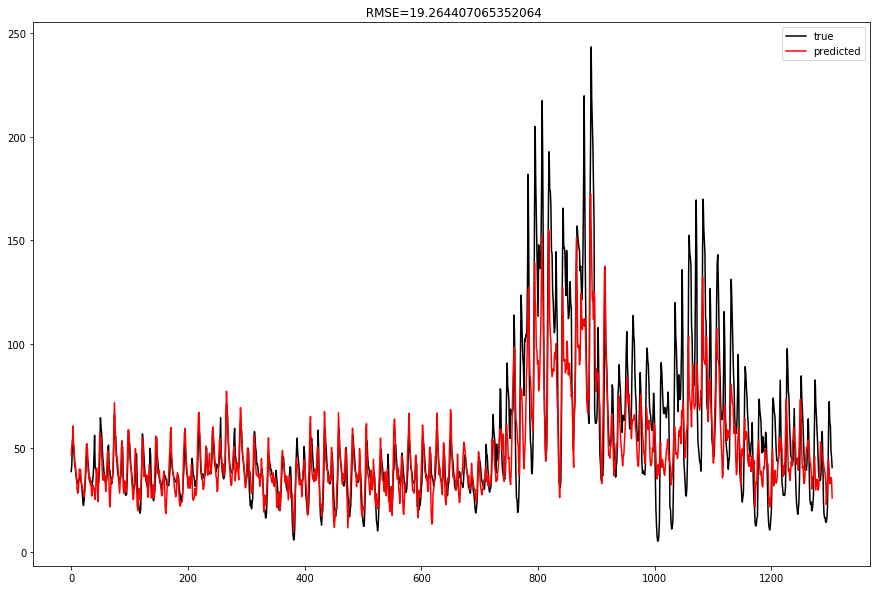

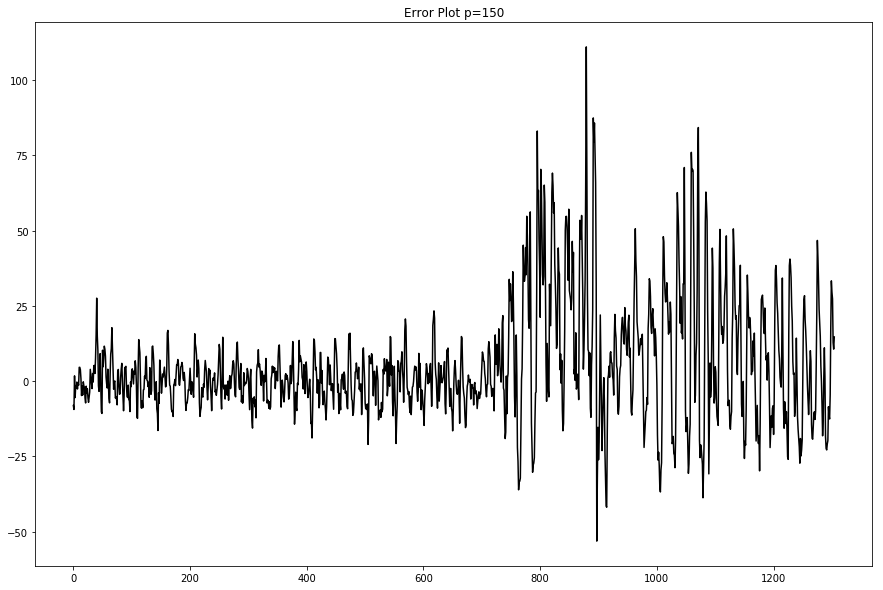

In [807]:
nn_test(X_test,y_test,nn,p)

Comparison

Mean Percentage Error=0.30708688474360674


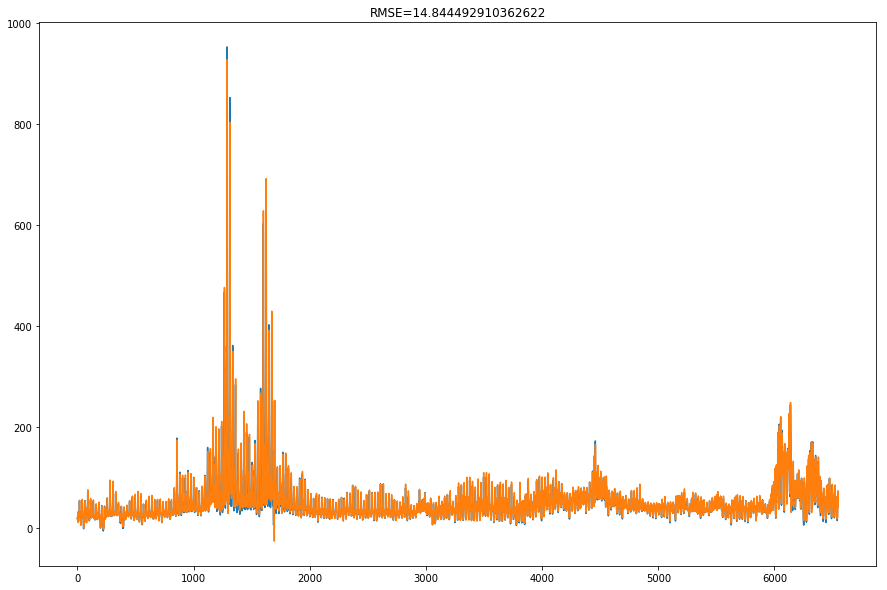

In [793]:
from statsmodels.tsa.arima_model import ARIMA

#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, Exog,P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q),exog=Exog)
    model_fit = model.fit(disp=-1)
    pred=Actual+model_fit.predict(1,len(Actual),exog=Exog)
    y_out=scaler.inverse_transform(Actual[1:].reshape(-1,1)).reshape(1,-1)[0]
    y_val=scaler.inverse_transform(pred[:-1].reshape(-1,1)).reshape(1,-1)[0]
    plt.figure(figsize=(15,10))
    plt.plot(y_out,label='true')
    plt.plot(y_val,label='predicted')
    plt.title('RMSE='+str(np.sqrt(mean_squared_error(y_out,y_val))))
    print('Mean Percentage Error='+str(np.sqrt(mean_squared_error(y_out,y_val))/np.mean(y_val)))
    #return prediction
StartARIMAForecasting(s[:-1],ng,2,1,1)

# Spread Spike Classification 

In [820]:
Renewable_d=np.array([np.mean(Df['Renewables'][i*12*24:12*24*(i+1)]) for i in range(len(Df)//288)])
NG_d=np.array([np.mean(Df['Natural gas'][i*12*24:12*24*(i+1)]) for i in range(len(Df)//288)])
Hydro_d=np.array([np.mean(Df['Large hydro'][i*12*24:12*24*(i+1)]) for i in range(len(Df)//288)])
Import_d=np.array([np.mean(Df['Imports'][i*12*24:12*24*(i+1)]) for i in range(len(Df)//288)])
Nuclear_d=np.array([np.mean(Df['Nuclear'][i*12*24:12*24*(i+1)]) for i in range(len(Df)//288)])
Coal_d=np.array([np.mean(Df['Coal'][i*12*24:12*24*(i+1)]) for i in range(len(Df)//288)])

In [821]:
ts=np.array(ts)

In [822]:
spread=[max(ts[i*24:24*(i+1)])-min(ts[i*24:24*(i+1)]) for i in range(len(s)//24)]

In [823]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler2 = MinMaxScaler()
renewable_d=scaler2.fit_transform(Renewable_d.reshape(-1,1)).reshape(1,-1)[0]
ng_d=scaler2.fit_transform(NG_d.reshape(-1,1)).reshape(1,-1)[0]
hydro_d=scaler2.fit_transform(Hydro_d.reshape(-1,1)).reshape(1,-1)[0]
imp_d=scaler2.fit_transform(Import_d.reshape(-1,1)).reshape(1,-1)[0]
nuc_d=scaler2.fit_transform(Nuclear_d.reshape(-1,1)).reshape(1,-1)[0]
coal_d=scaler2.fit_transform(Coal_d.reshape(-1,1)).reshape(1,-1)[0]
spread_d=scaler2.fit_transform(np.array(spread).reshape(-1,1)).reshape(1,-1)[0]

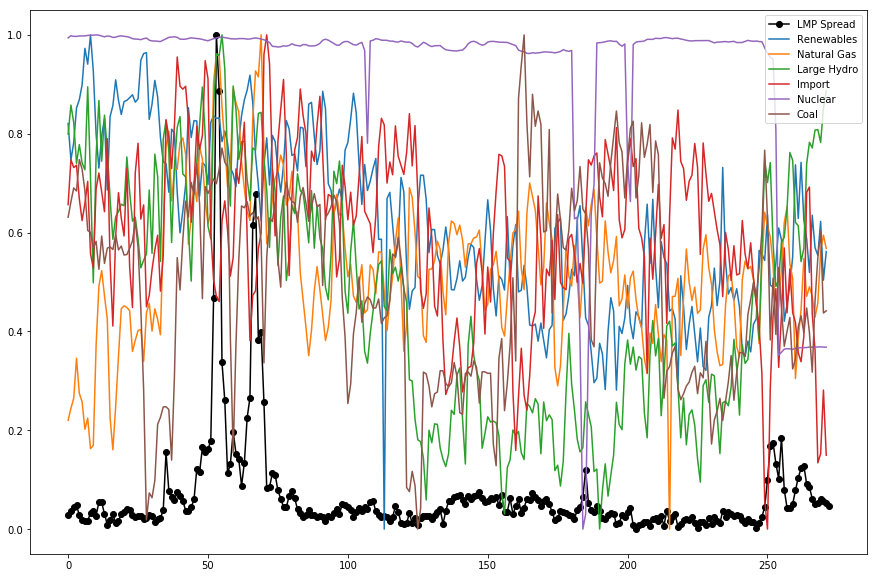

In [824]:
plt.figure(figsize=(15,10))
plt.plot(spread_d,'ko-',label='LMP Spread')
plt.plot(renewable_d,label='Renewables')
plt.plot(ng_d,label='Natural Gas')
plt.plot(hydro_d,label='Large Hydro')
plt.plot(imp_d,label='Import')
plt.plot(nuc_d,label='Nuclear')
plt.plot(coal_d,label='Coal')
plt.legend()

In [825]:
dic={'spread':np.array(spread),'renewable':Renewable_d,'natural gas':NG_d,'hydro':Hydro_d,'import':Import_d,'nuclear':Nuclear_d,'coal':Coal_d}
exog=pd.DataFrame(data=dic)

ValueError: arrays must all be same length

In [826]:
exog.keys()

Index(['spread', 'renewable', 'natural gas', 'hydro', 'import', 'nuclear',
       'coal'],
      dtype='object')

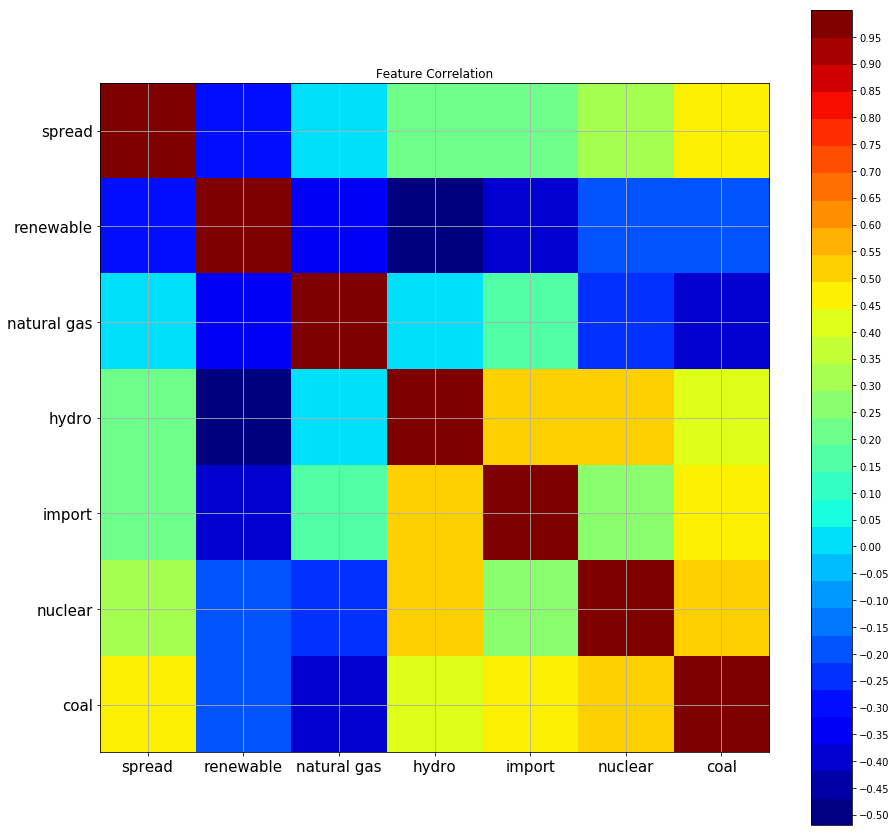

In [268]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=['']+list(df.keys())
    ax1.set_xticklabels(labels,fontsize=15)
    ax1.set_yticklabels(labels,fontsize=15)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=np.arange(-1.,1.,0.05))
    plt.show()

correlation_matrix(exog)


In [245]:
def nn_train(X_train,y_train,p,epoch,b_s):
   
    model=Sequential()
   
    model.add(Dense(10, input_dim=p, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(5, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Fit the model
    model.fit(X_train, y_train, epochs=epoch, batch_size=b_s)
# evaluate the model
    return model
def nn_test(X_out,y_out,nn,p):
    
    y_val=np.array(nn.predict(X_out)).reshape(1,-1)[0]
    y_out=scaler2.inverse_transform(y_out.reshape(-1,1)).reshape(1,-1)[0]
    y_val=scaler2.inverse_transform(y_val.reshape(-1,1)).reshape(1,-1)[0]
    #print(y_val,y_out)
    plt.figure(figsize=(15,10))
    plt.plot(y_out,'k',label='true')
    plt.plot(y_val,'r',label='predicted')
    plt.title(' RMSE='+str(np.sqrt(mean_squared_error(y_val,y_out))))
    plt.legend()
    plt.figure(figsize=(15,10))
    error=y_out-y_val
    plt.plot(error,'k')
    plt.title('Error Plot p='+str(p))
    
    print('Mean Percentage Error='+str(np.sqrt(mean_squared_error(y_out,y_val))/np.mean(y_val)))

In [260]:
data_s=np.array([[renewable_d[i],ng_d[i],hydro_d[i],imp_d[i],nuc_d[i],coal_d[i],spread_d[i-1],spread_d[i]] for i in range(30-1)])
size_s=int(len(data_s)*0.8)
train_s, test_s = data_s[0:size_s,:], data_s[size_s:len(data_s),:]
X_train_s,X_test_s=train_s[:,0:-1],test_s[:,0:-1]
y_train_s,y_test_s=train_s[:,-1],test_s[:,-1]
p_s=X_train_s.shape[1]

In [263]:
nn_s=nn_train(X_train_s,y_train_s,p_s,50,10)

Epoch 1/50
23/23 [==============================] - 2s 87ms/step - loss: 0.1189
Epoch 2/50
23/23 [==============================] - 0s 218us/step - loss: 0.1100
Epoch 3/50
23/23 [==============================] - 0s 392us/step - loss: 0.1022
Epoch 4/50
23/23 [==============================] - 0s 304us/step - loss: 0.0938
Epoch 5/50
23/23 [==============================] - 0s 435us/step - loss: 0.0874
Epoch 6/50
23/23 [==============================] - 0s 305us/step - loss: 0.0808
Epoch 7/50
23/23 [==============================] - 0s 435us/step - loss: 0.0756
Epoch 8/50
23/23 [==============================] - 0s 435us/step - loss: 0.0705
Epoch 9/50
23/23 [==============================] - 0s 348us/step - loss: 0.0663
Epoch 10/50
23/23 [==============================] - 0s 392us/step - loss: 0.0631
Epoch 11/50
23/23 [==============================] - 0s 305us/step - loss: 0.0597
Epoch 12/50
23/23 [==============================] - 0s 435us/step - loss: 0.0579
Epoch 13/50
23/23 [=======

Mean Percentage Error=0.23868702870788494


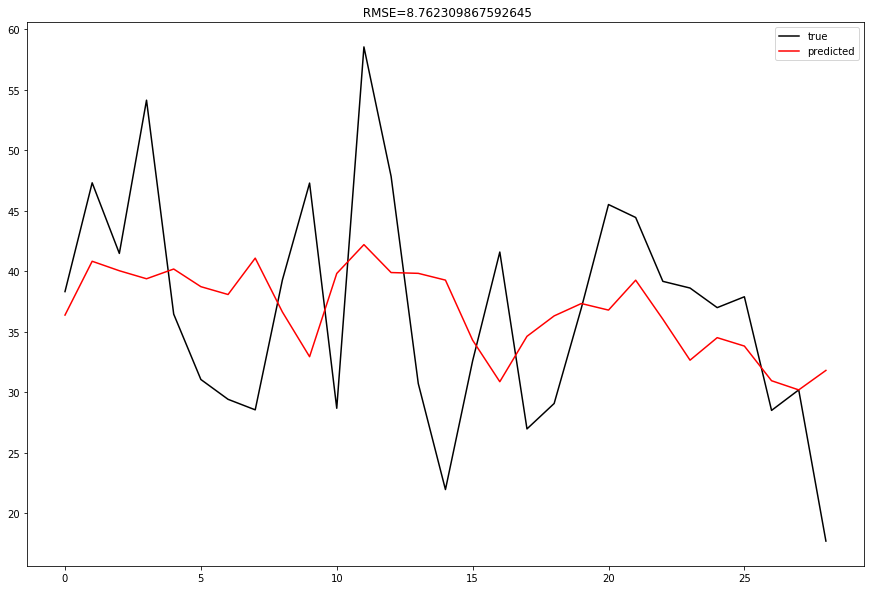

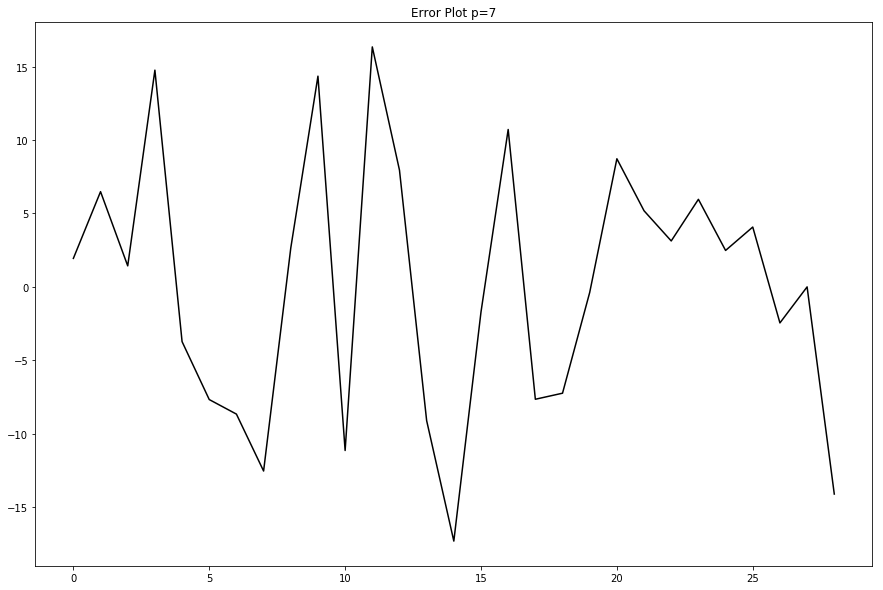

In [264]:
nn_test(data_s[:,0:-1],data_s[:,-1],nn_s,p_s)

# Nodal Correlations

In [270]:
Df3 = pd.read_csv('Intraday_spread_17-18.csv')
Df3=Df3.drop(['Dates'],axis=1)

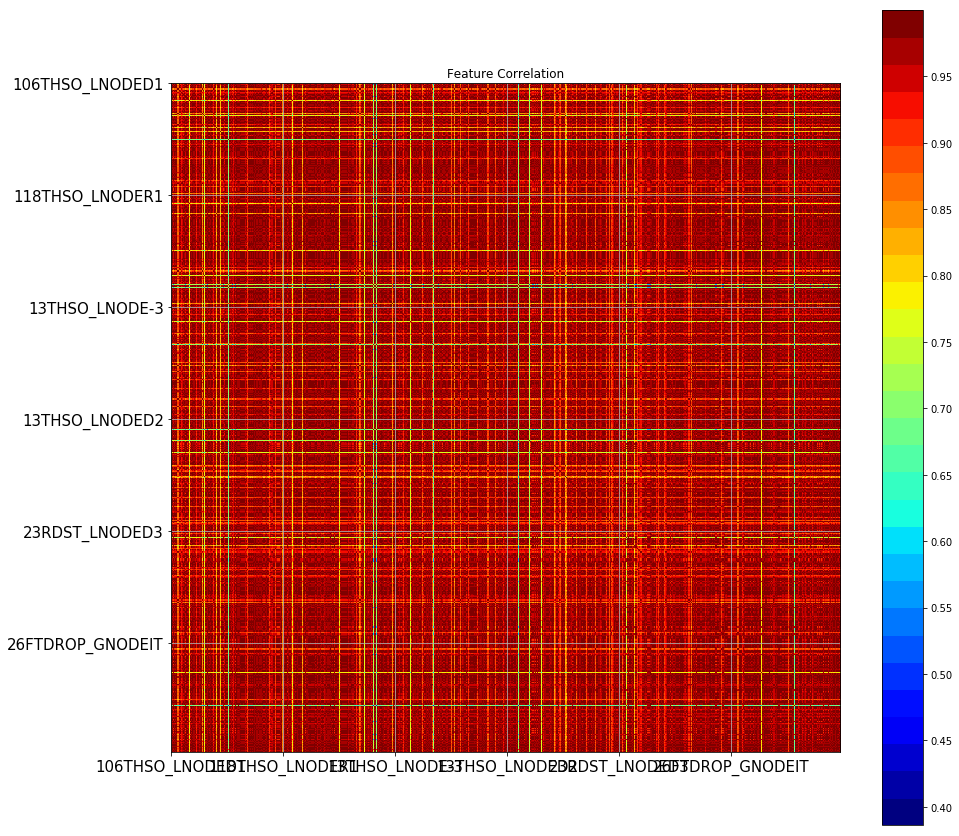

In [271]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=['']+list(df.keys())
    ax1.set_xticklabels(labels,fontsize=15)
    ax1.set_yticklabels(labels,fontsize=15)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=np.arange(-1.,1.,0.05))
    plt.show()

correlation_matrix(Df3)

#### It is evident that all nodal sequences have significant positive correlations with very few exceptions.  